# K-S Traveling

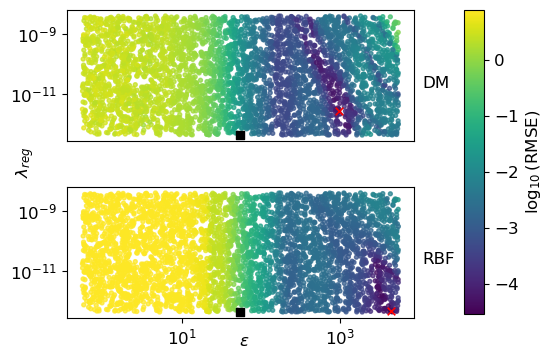

In [19]:
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))
from diffusion_maps import model_dir, data_dir, external_dir

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pickle


devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
num_points_lst = [6000]
map_type = "skip-connection"
test_trials = 1
steps = 14000 

plt.rcParams.update({"font.size": 12})


global_min = np.inf
global_max = -np.inf
existing = {}

for mode in modes:
    for num_points in num_points_lst:
        fname = model_dir + f"/ks_travelling/ks_travelling_cv_{mode}_{num_points}_{map_type}_dt_0.02.pkl"
        if not os.path.exists(fname):
            continue
        with open(fname, "rb") as f:
            df = pickle.load(f)
        existing[(mode, num_points)] = df

        rmse = df["rmse"]
        mask = np.isfinite(rmse) & (rmse > 0)
        if not np.any(mask):
            continue
        log_rmse = np.log10(rmse[mask])
        global_min = min(global_min, np.nanmin(log_rmse))
        global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

nrows = len(modes)
ncols = len(num_points_lst)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5, 4),
    sharex=False, sharey=False
)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    row = i_mode
    for j, num_points in enumerate(num_points_lst):
        
        ax = axs[row]

        key = (mode, num_points)
        if key not in existing:
            ax.set_visible(False)
            continue

        cv_results = existing[key]
        eps   = cv_results["epsilon"]
        lam   = cv_results["lambda"]
        eps_c = cv_results["epsilon_c"]
        lam_m = cv_results["lambda_min"]
        rmse  = cv_results["rmse"]

        ax.scatter(
            eps,
            lam,
            c=np.log10(rmse),
            cmap=cmap,
            norm=norm,
            s=8,
            alpha=0.75,
        )

        idx = np.nanargmin(rmse)
        ax.scatter([eps[idx]], [lam[idx]], c="red", marker="x", s=30, linewidths=1.2)
        ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)
        # ax.scatter(_eps_c, 10**lam_m, c="black", marker='x', s=30)

        ax.set_xscale("log")
        ax.set_yscale("log")

        if j == ncols - 1:
            ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
            ax.yaxis.set_label_position("right")


x0 = fig.subplotpars.right + 0.1
cbar_ax = fig.add_axes([x0, 0.12, 0.04, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel(r"$\log_{10}(\mathrm{RMSE})$")

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.02, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

x_locator = LogLocator(base=10, numticks=3)  # adjust numticks to taste
y_locator = LogLocator(base=10, numticks=3)

for r in range(nrows):
    ax = axs[r]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

axs[1].tick_params(axis="x", which="both", bottom=True, labelbottom=True)
axs[1].xaxis.set_major_locator(x_locator)

fig.savefig("./pics/ks_travelling_cv_results.png", bbox_inches="tight", dpi=300, transparent=True)

In [2]:
import numpy as np
import polars as pl
import pickle
import cupy as cp
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from tqdm import tqdm
from diffusion_maps.src.krr_model import Modeler

def load_data():
    NT = 5000000
    SKP = 500000
    DT = 0.001
    TS = 10
    data = pickle.load(open(data_dir + f"/cached_data/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
    dt = data["dt"]; xx = data["x"]; tt = data["t"]
    uu = data["udata"].astype(np.float64)

    Nx, Nt = len(xx), len(tt)
    assert uu.shape == (Nt, Nx)

    data_train = uu[:num_points:2]

    mean = np.mean(data_train, axis=0)
    std  = np.std(data_train, axis=0)
    data_train_n = (data_train - mean) / std

    data_train_x = data_train_n[:-1]
    data_train_y = data_train_n[1:]

    data_val = data_train.copy()

    data_test = []
    start0 = num_points
    for _ in range(test_trials):
        s = start0 + _ * steps
        e = s + steps
        data_test.append([(uu[s:e:2] - mean) / std])

    return dt, data_train_x, data_train_y, data_val, data_test, mean, std

num_points = 6000
steps      = 14000
dt_plot    = 0.02
DOMAIN_SIZE = 2 * np.pi
N_DOF = 64

x = np.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)
t = np.linspace(0, dt_plot * (steps//2 - 1), steps//2)
X, T = np.meshgrid(x, t)
validation_repeats = 5
validation_horizon = num_points
test_trials = 1
_, data_train_x, data_train_y, data_val, data_test, mean, std = load_data()

mode_lst = ['diffusion', 'rbf']

def forecast_path(mode, map_type):
    opts = {'map_type': map_type, 
            'pipeline': 'single',
            'inp': data_train_x, 
            'out': data_train_y}

    cv_filename = model_dir + f"/ks_traveling/ks_traveling_cv_{mode}_{num_points}_{map_type}_dt_0.02.pkl"
    with open(cv_filename, "rb") as f:
        cv = pickle.load(f)
    i   = np.argmin(cv["rmse"])
    eps = float(cv["epsilon"][i])
    lam = float(cv["lambda"][i])
    print(f"epsilon = {eps}, lambda = {lam}")

    model = Modeler(**opts)
    distance_matrix = cp.linalg.norm(
            cp.array(model.inp[:, None]) - cp.array(model.inp[None]), axis=-1
        )
    model.fit_model(eps, lam, mode, distance_matrix=distance_matrix)

    with cp.cuda.Device(0):
        true_cp = cp.array(data_test[0]).reshape(test_trials, steps//2, N_DOF)
        true_cp = true_cp.transpose(1, 0, 2)
        x0      = cp.asarray(true_cp[0])

        preds = [cp.array(x0).get()]
        x = x0
        
        for _ in tqdm(range(steps//2 - 1)):
            x = model.forecast(x)
            preds.append(x.get())
            
    pred_np = np.asarray(preds)
    true_np = true_cp.get()
    return model, true_np, pred_np

def prettify_cbar(cb, nbins=5, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    cb.update_ticks()
    if ticks is not None:
        cb.set_ticks(ticks)
        cb.set_ticklabels([f"{t:g}" for t in ticks])

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.02):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom  = min(bottoms)
    top     = max(tops)
    height  = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

results = {}
mdls = []
for mode in mode_lst:
    
    mdl, true_m, pred_s = forecast_path(mode, 'skip-connection')
    mdls.append(mdl)
    
    err_s = np.abs(pred_s - true_m)
    rmse_s = float(np.sqrt(np.mean((pred_s - true_m) ** 2)))
    results[mode] = {
        'true': true_m.squeeze(),
        'pred_skip':   pred_s.squeeze(),
        'err_skip':    err_s.squeeze(),
        'rmse_skip':   rmse_s,
    }
    rmse_at_final_t = np.sqrt(np.mean(err_s**2, axis=-1))[-1][0]
    
    print(f"mode = {mode}, RMSE at final time = {rmse_at_final_t:.3e}, mean RMSE = {rmse_s:.3e}")

epsilon = 956.1597851065964, lambda = 2.5665506809342375e-12


100%|██████████| 6999/6999 [00:03<00:00, 2256.71it/s]


mode = diffusion, RMSE at final time = nan, mean RMSE = nan
epsilon = 4376.117625908289, lambda = 4.410783204682812e-13


100%|██████████| 6999/6999 [00:01<00:00, 5355.56it/s]


mode = rbf, RMSE at final time = 6.653e+01, mean RMSE = 6.400e+01


In [11]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter, LogLocator, LogFormatter
from matplotlib.colors import LogNorm

class NumpyCoreCompatUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module.startswith("numpy._core"):
            module = module.replace("numpy._core", "numpy.core")
        return super().find_class(module, name)

NT = 5000000
SKP = 500000
DT = 0.001
TS = 10
data = pickle.load(open(data_dir + f"/cached_data/ksdata_traveling_NT_{NT}_SKP_{SKP}_dt_{DT}_ts_{TS}.pkl", "rb"))
dt = data["dt"]; xx = data["x"]; tt = data["t"]
uu = data["udata"].astype(np.float64)


Noffset = 6000
Ntest = 14000
steps = Ntest
tt = tt[:Ntest]
tk = tt[::2]
truePath = uu[Noffset:Noffset+Ntest:2]
num_points = 6000

"""
    Kernel Methods (DM / RBF)
"""
mode_lst = ['diffusion', 'rbf', 'gmkrr', 'candyman','node', 'ldnet']
results = {}
for mode in mode_lst:
    results[mode] = {}

for mode in ['diffusion', 'rbf']:
    map_type = "skip-connection"
    results_path = model_dir + f"/ks_traveling/ks_traveling_{mode}_{num_points}_{map_type}_dt_0.02.pkl"
    with open(results_path, 'rb') as f:
        results_df = pickle.load(f)
    results[mode]['epsilon'] = results_df["epsilon"]
    results[mode]['lambda'] = results_df["lambda"]
    
    # results[mode]['error'] = results_df["error"].to_numpy() 
    # paths = np.zeros((Ntest//2, uu.shape[1]))

    paths = results_df['path'].squeeze()
    error = np.abs(truePath - paths)
    results[mode]['path'] = paths
    results[mode]['error'] = error
    results[mode]['rmse'] = np.sqrt(np.mean((error)**2))


pre_trained_path = external_dir + "/trained_mdls/"
"""
    GMKRR
"""
gmkrr_file = pre_trained_path + "ks_trf_100.dat"
with open(gmkrr_file, "rb") as file:
    gmkrr_results = pickle.load(file)
gmkrr_pred = gmkrr_results[0][::2]
gmkrr_error = np.abs(truePath - gmkrr_pred)
results['gmkrr']['path'] = gmkrr_pred
results['gmkrr']['error'] = gmkrr_error
results['gmkrr']['rmse'] = np.sqrt(np.mean((gmkrr_error)**2))

"""
    CANDYMan
"""
candyman_file = pre_trained_path + "kst.pkl"
with open(candyman_file, "rb") as file:
    res = pickle.load(file)
candyman_path = res[2][:14000:2, :64]
results['candyman']['path'] = candyman_path
candyman_error = np.abs(truePath - candyman_path)
results['candyman']['error'] = candyman_error
results['candyman']['rmse'] = np.sqrt(np.mean((candyman_error)**2))

"""
    NODE
"""
node_file = pre_trained_path + "ks_trf_nde.pkl"
with open(node_file, "rb") as file:
    res = NumpyCoreCompatUnpickler(file).load()
node_path = res[0][::2]
node_error = np.abs(truePath - node_path)
results['node']['path'] = node_path
results['node']['error'] = node_error
results['node']['rmse'] = np.sqrt(np.mean((node_error)**2))

"""
    LDNet
"""
ldnet_file = pre_trained_path + "ks_trf_ldn.pkl"
with open(ldnet_file, "rb") as file:
    res = pickle.load(file)
ldnet_pred = res[0][::2]
ldnet_error = np.abs(truePath - ldnet_pred)
results['ldnet']['path'] = ldnet_pred
results['ldnet']['error'] = ldnet_error
results['ldnet']['rmse'] = np.sqrt(np.mean((ldnet_error)**2))

In [12]:
from sklearn.manifold import Isomap
Nm = 5000
Nt = 500
K = int(np.sqrt(Nm))
isom = Isomap(n_neighbors=K, n_components=3)

dat = uu[:Nm]
X = isom.fit_transform(dat).T
Xt = X[:, :Nt]

/tmp/ipykernel_2932338/3296371704.py:91: UserWarning: Log scale: values of z <= 0 have been masked
  im_dm_err  = ax_dm_err.contourf(tk, xx, results['diffusion']['error'].T, levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_2932338/3296371704.py:92: UserWarning: Log scale: values of z <= 0 have been masked
  im_rbf_err = ax_rbf_err.contourf(tk, xx, results['rbf']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_2932338/3296371704.py:93: UserWarning: Log scale: values of z <= 0 have been masked
  im_gmkrr_err = ax_gmkrr_err.contourf(tk, xx, results['gmkrr']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_2932338/3296371704.py:95: UserWarning: Log scale: values of z <= 0 have been masked
  im_candyman_err = ax_candyman_err.contourf(tk, xx, results['candyman']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
/tmp/ipykernel_2932338/32963

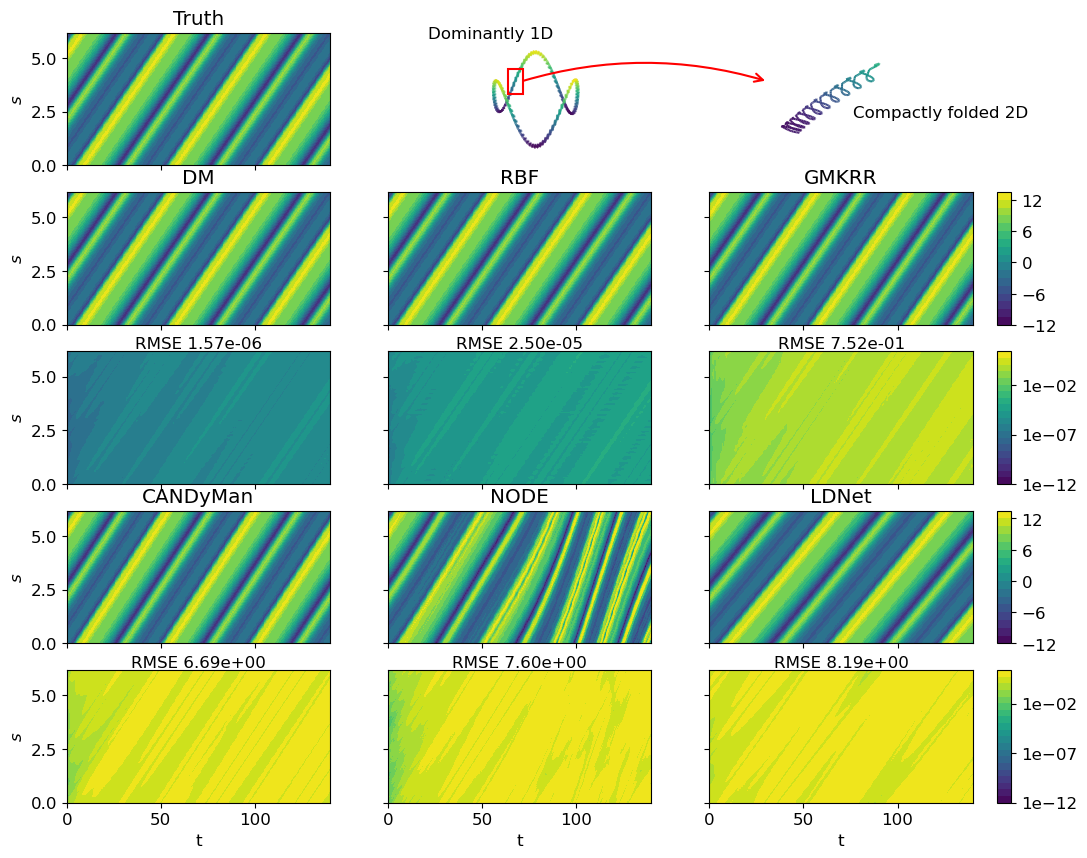

In [20]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(12, 10))
gs  = fig.add_gridspec(nrows=5, ncols=3, right=0.88, hspace=0.20, wspace=0.22)

fontsize=12

# Truth
ax_truth    = fig.add_subplot(gs[0, 0])
gs_top = gs[0, 1:].subgridspec(1, 2, wspace=0.0)

ax_im_full  = fig.add_subplot(gs_top[0, 0], projection='3d')
ax_im_zoom  = fig.add_subplot(gs_top[0, 1], projection='3d')


# DM / RBF/ GMKRR
ax_dm_skip  = fig.add_subplot(gs[1, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_skip = fig.add_subplot(gs[1, 1], sharex=ax_truth, sharey=ax_truth)
ax_gmkrr = fig.add_subplot(gs[1, 2], sharex=ax_truth, sharey=ax_truth)

# CANDYMan / NODE/ LDNet
ax_candyman = fig.add_subplot(gs[3, 0], sharex=ax_truth, sharey=ax_truth)
ax_node = fig.add_subplot(gs[3, 1], sharex=ax_truth, sharey=ax_truth)
ax_ldnet = fig.add_subplot(gs[3, 2], sharex=ax_truth, sharey=ax_truth)

# Error 
ax_dm_err  = fig.add_subplot(gs[2, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_err = fig.add_subplot(gs[2, 1], sharex=ax_truth, sharey=ax_truth)
ax_gmkrr_err = fig.add_subplot(gs[2, 2], sharex=ax_truth, sharey=ax_truth)

ax_candyman_err = fig.add_subplot(gs[4, 0], sharex=ax_truth, sharey=ax_truth)
ax_node_err = fig.add_subplot(gs[4, 1], sharex=ax_truth, sharey=ax_truth)
ax_ldnet_err = fig.add_subplot(gs[4, 2], sharex=ax_truth, sharey=ax_truth)



im_truth = ax_truth.contourf(tk, xx, truePath.T, levels=21)
truth_levels = im_truth.levels

im_dm_skip  = ax_dm_skip.contourf(tk, xx, results['diffusion']['path'].T, levels=truth_levels)
im_rbf_skip = ax_rbf_skip.contourf(tk, xx, results['rbf']['path'].T,       levels=truth_levels)
im_gmkrr = ax_gmkrr.contourf(tk, xx, results['gmkrr']['path'].T,       levels=truth_levels)

im_candyman  = ax_candyman.contourf(tk, xx, results['candyman']['path'].T, levels=truth_levels)
im_candyman  = ax_node.contourf(tk, xx, results['node']['path'].T, levels=truth_levels)
im_ldnet = ax_ldnet.contourf(tk, xx, results['ldnet']['path'].T,       levels=truth_levels)

# isomap
icmap = plt.get_cmap("viridis")
norm = Normalize(vmin=X[2].min(), vmax=X[2].max())

# Full trajectory (top middle)
points = X.T.reshape(-1, 1, 3)                      # (N, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)  # (N-1, 2, 3)

lc_full = Line3DCollection(segments, cmap=icmap, norm=norm)
lc_full.set_array(X[2][:-1])                        # colors along the line
ax_im_full.add_collection3d(lc_full)
ax_im_full.set_xlim(X[0].min(), X[0].max())
ax_im_full.set_ylim(X[1].min(), X[1].max())
ax_im_full.set_zlim(X[2].min(), X[2].max())
ax_im_full.axis('off')

# Zoomed trajectory (top right)
points_t = Xt.T.reshape(-1, 1, 3)
segments_t = np.concatenate([points_t[:-1], points_t[1:]], axis=1)

lc_zoom = Line3DCollection(segments_t, cmap=icmap, norm=norm)
lc_zoom.set_array(Xt[2][:-1])                       # still uses same norm
ax_im_zoom.add_collection3d(lc_zoom)
ax_im_zoom.axis('off')

err_arrays = [
    np.asarray(results['diffusion']['error']),
    np.asarray(results['rbf']['error']),
    np.asarray(results['gmkrr']['error']),
    np.asarray(results['candyman']['error']),
    np.asarray(results['node']['error']),
    np.asarray(results['ldnet']['error'])
]
vmax_err = max(float(np.nanmax(e)) for e in err_arrays if e.size)
def _min_pos(a):
    a = np.asarray(a)
    a_pos = a[(a > 0) & np.isfinite(a)]
    return float(a_pos.min()) if a_pos.size else np.inf
min_pos = min(_min_pos(e) for e in err_arrays)
vmin_err = 1e-12 if not np.isfinite(min_pos) else max(min_pos, 1e-12)

levels_err = np.logspace(np.log10(vmin_err), np.log10(vmax_err), 21)
im_dm_err  = ax_dm_err.contourf(tk, xx, results['diffusion']['error'].T, levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_rbf_err = ax_rbf_err.contourf(tk, xx, results['rbf']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_gmkrr_err = ax_gmkrr_err.contourf(tk, xx, results['gmkrr']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))

im_candyman_err = ax_candyman_err.contourf(tk, xx, results['candyman']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_node_err = ax_node_err.contourf(tk, xx, results['node']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))
im_ldnet_err = ax_ldnet_err.contourf(tk, xx, results['ldnet']['error'].T,       levels=levels_err, norm=LogNorm(vmin=vmin_err, vmax=vmax_err))


ax_truth.set_title('Truth')
ax_dm_skip.set_title('DM'); ax_rbf_skip.set_title('RBF'); ax_gmkrr.set_title('GMKRR')
ax_candyman.set_title('CANDyMan'); ax_node.set_title('NODE'); ax_ldnet.set_title('LDNet')

ax_dm_err.set_title(f"RMSE {results['diffusion']['rmse']:.2e}", fontsize=12, pad=2)
ax_rbf_err.set_title(f"RMSE {results['rbf']['rmse']:.2e}",     fontsize=12, pad=2)
ax_gmkrr_err.set_title(f"RMSE {results['gmkrr']['rmse']:.2e}",     fontsize=12, pad=2)

ax_candyman_err.set_title(f"RMSE {results['candyman']['rmse']:.2e}",     fontsize=12, pad=2)
ax_node_err.set_title(f"RMSE {results['node']['rmse']:.2e}",     fontsize=12, pad=2)
ax_ldnet_err.set_title(f"RMSE {results['ldnet']['rmse']:.2e}",     fontsize=12, pad=2)


ax_dm_skip.set_ylabel('$s$', fontsize=fontsize)
ax_dm_err.set_ylabel('$s$', fontsize=fontsize)
ax_candyman.set_ylabel('$s$', fontsize=fontsize)
ax_candyman_err.set_ylabel('$s$', fontsize=fontsize)
for ax in (ax_dm_err, ax_rbf_err):
    ax.set_xlabel('$t$', fontsize=fontsize)

ax_truth.set_xlim(tt[0], tt[-1])
ax_truth.set_xticks([0.0, 50.0, 100.0])


all_axes = [ax_truth, ax_dm_skip, ax_rbf_skip, ax_dm_err, ax_rbf_err]
for ax in all_axes:
    ax.tick_params(labelbottom=True, labelleft=True, bottom=True, left=True)


def prettify_cbar(cb, nbins=6, ticks=None):
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.update_ticks()

def prettify_cbar_log(cb, base=10):
    cb.locator   = LogLocator(base=base)
    cb.formatter = LogFormatter(base=base)
    cb.update_ticks()

def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.012):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom, top = min(bottoms), max(tops)
    height = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax)

axes_shared = [ax_truth, 
               ax_dm_skip, ax_rbf_skip, ax_gmkrr, 
               ax_candyman, ax_node, ax_ldnet,
               ax_dm_err, ax_rbf_err, ax_gmkrr_err,
               ax_candyman_err, ax_node_err, ax_ldnet_err]
for ax in axes_shared:
    ax.set_xlim(ax_truth.get_xlim())
    ax.set_ylim(ax_truth.get_ylim())
    ax.set_autoscale_on(False)
    ax.label_outer()

ax_candyman_err.set_xlabel("t", fontsize=12)
ax_node_err.set_xlabel("t", fontsize=12)
ax_ldnet_err.set_xlabel("t", fontsize=12)

row0_axes = [ax_truth]
row2_axes = [ax_dm_skip, ax_rbf_skip, ax_gmkrr]
row3_axes = [ax_dm_err, ax_rbf_err, ax_gmkrr_err]
row4_axes = [ax_candyman, ax_node, ax_ldnet]
row5_axes = [ax_candyman_err, ax_node_err, ax_ldnet_err]

cb2 = add_row_colorbar(fig, row2_axes, im_dm_skip, left=0.90, width=0.012)
cb3 = add_row_colorbar(fig, row3_axes, im_dm_err, left=0.90, width=0.012)
cb4 = add_row_colorbar(fig, row4_axes, im_candyman, left=0.90, width=0.012)
cb5 = add_row_colorbar(fig, row5_axes, im_candyman_err, left=0.90, width=0.012)
ax_truth.set_ylabel('$s$', fontsize=fontsize)

ticks = [-12, -6, 0, 6, 12]

prettify_cbar(cb2, nbins=5, ticks=ticks)
prettify_cbar(cb4, nbins=5, ticks=ticks)
prettify_cbar_log(cb3, base=10)
prettify_cbar_log(cb5, base=10)

plt.text(
    -0.3, 1.05, "Dominantly 1D",
    transform=ax_im_full.transAxes,
    ha="left", va="top",
    fontsize=12,
)
plt.text(
    0.7, 0.45, "Compactly folded 2D",
    transform=ax_im_zoom.transAxes,
    ha="left", va="top",
    fontsize=12,
)

ax_im_full.text2D(
    0.34, 0.6, " ",
    transform=ax_im_full.transAxes,
    bbox=dict(
        boxstyle="square",
        edgecolor="red",
        facecolor="none",
        linewidth=1.5,
    ),
)

bbox_zoom = ax_im_zoom.get_position()
bbox_full = ax_im_full.get_position()

x_start = bbox_zoom.x1 - 0.31
y_start = 0.5 * bbox_zoom.y0 + 0.52 * bbox_zoom.y1

x_end = bbox_full.x0 + 0.25
y_end = 0.5 * bbox_full.y0 + 0.52 * bbox_full.y1

import matplotlib.patches as mpatches
arrow = mpatches.FancyArrowPatch(
    (x_start, y_start),
    (x_end, y_end),
    transform=fig.transFigure,
    arrowstyle="->",
    connectionstyle="arc3,rad=-0.15",
    mutation_scale=15,
    linewidth=1.5,
    color="red",
)

fig.add_artist(arrow)

fig.savefig(f"pics/ks_travelling_prediction_results.png",
            bbox_inches="tight", dpi=300, transparent=True)



## Chaotic

mode = diffusion, map_type = direct, N = 2048, maxvpt = 0.9918666666666667
mode = diffusion, map_type = direct, N = 4096, maxvpt = 3.0702
mode = diffusion, map_type = direct, N = 8192, maxvpt = 5.006633333333333
mode = diffusion, map_type = direct, N = 16384, maxvpt = 6.890033333333332
mode = rbf, map_type = direct, N = 2048, maxvpt = 0.8585666666666668
mode = rbf, map_type = direct, N = 4096, maxvpt = 2.6187
mode = rbf, map_type = direct, N = 8192, maxvpt = 3.381233333333333
mode = rbf, map_type = direct, N = 16384, maxvpt = 5.633


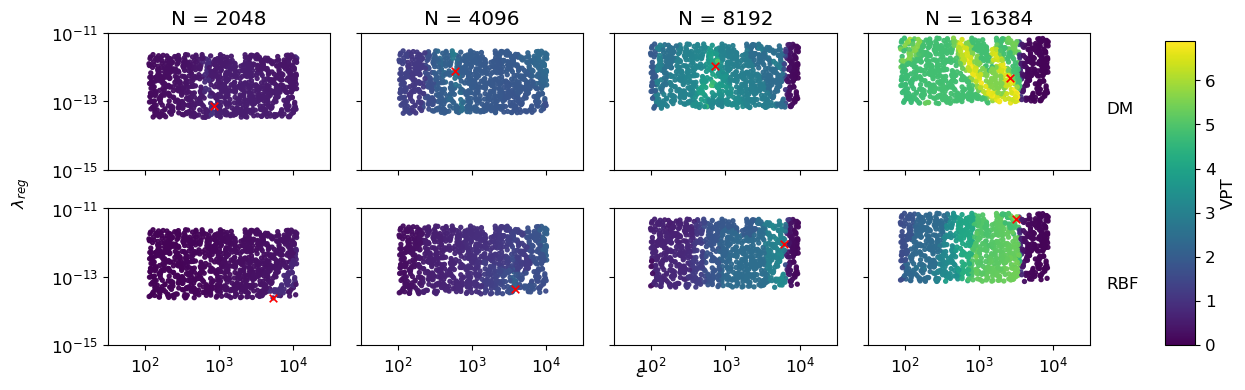

In [10]:
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))

from diffusion_maps import model_dir

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl

title = "ks_chaotic"

num_points_lst = [2048, 4096, 8192, 16384]

row_order = [
    ("diffusion", "direct"),
    ("rbf",       "direct"),
]
model_labels = {"diffusion": "DM", "rbf": "RBF"}
map_type_labels = {"direct": "Direct", "skip-connection": "Skip\nConnection"}

cmap = "viridis"
point_size = 8
best_size = 22
alpha_points = 0.95
devices = 4

plt.rcParams.update({"font.size": 12})

cv_filename = lambda mode, n, map_type: model_dir + f"/ks_chaotic/ks_chaotic_cv_results_{mode}_{n}_{map_type}_vl_4000.pkl"

cv_data = {}
vpt_min, vpt_max = np.inf, -np.inf
eps_min, eps_max = np.inf, -np.inf
lam_min, lam_max = np.inf, -np.inf

mdl_idx = 0

for mode, map_type in row_order:
    for num_points in num_points_lst:
        fp = cv_filename(mode, num_points, map_type)
        if not os.path.exists(fp):
            print("File does not exist")
            continue
        try:
            with open(fp, "rb") as f:
                df = pickle.load(f)
        except Exception as e:
            print(f"[WARN] failed to read {fp}: {e}")
            continue
        eps = df["epsilon"][mdl_idx]
        lam = df["lambda"][mdl_idx]
        vpt = df["vpt"][mdl_idx]
        print(f"mode = {mode}, map_type = {map_type}, N = {num_points}, maxvpt = {np.max(vpt)}")

        lamm = df["lambda_min"][mdl_idx]
        epsc = df["epsilon_c"][mdl_idx]
        valid = (
            np.isfinite(vpt) & (vpt >= 0)
        )

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]
        cv_data[(mode, map_type, num_points)] = dict(eps=eps, lam=lam, vpt=vpt, lamm=lamm, epsc=epsc)
        vpt_min = min(vpt_min, float(np.min(vpt_v)))
        vpt_max = max(vpt_max, float(np.max(vpt_v)))
        eps_min = min(eps_min, float(eps_v.min()))
        eps_max = max(eps_max, float(eps_v.max()))
        lam_min = min(lam_min, float(lam_v.min()))
        lam_max = max(lam_max, float(lam_v.max()))


if not np.isfinite(vpt_min) or not np.isfinite(vpt_max):
    raise RuntimeError("No valid τ_f values found in CV files; cannot plot.")

norm = mpl.colors.Normalize(vmin=vpt_min, vmax=vpt_max)

def pad_log_bounds(lo, hi, pad=0.05):
    return lo * (1 - pad), hi * (1 + pad)

eps_lo, eps_hi = pad_log_bounds(eps_min, eps_max)
lam_lo, lam_hi = pad_log_bounds(lam_min, lam_max)

rows, cols = len(row_order), len(num_points_lst)
fig, axs = plt.subplots(rows, cols, figsize=(15, 4), sharex=False, sharey=False)

RIGHT   = 0.78   
WSPACE  = 0.14  
HSPACE  = 0.28 
GAP     = 0.13
CBAR_W  = 0.028
BOTTOM, TOP = 0.12, 0.90

if rows == 1 and cols == 1:
    axs = np.array([[axs]])
elif rows == 1:
    axs = np.array([axs])
elif cols == 1:
    axs = axs.reshape(rows, 1)

fig.subplots_adjust(right=RIGHT, wspace=WSPACE, hspace=HSPACE, bottom=BOTTOM, top=TOP)

sc_last = None

for r, (mode, map_type) in enumerate(row_order):
    for c, num_points in enumerate(num_points_lst):
        ax = axs[r, c]

        if r == 0:
            ax.set_title(f"N = {num_points}")

        if c == cols - 1:
            ax.set_ylabel(f"{model_labels[mode]}", rotation=0,
                          labelpad=12, ha="left")
            ax.yaxis.set_label_position("right")

        key = (mode, map_type, num_points)
        if key not in cv_data:
            ax.set_xscale("log"); ax.set_yscale("log")
            ax.set_xlim(eps_lo, eps_hi); ax.set_ylim(lam_lo, lam_hi)
            ax.grid(True, which="both", alpha=0.25)
            continue

        D = cv_data[key]
        eps = D["eps"]; lam = D["lam"]; vpt = D["vpt"]
        eps_c = D["epsc"]
        lam_m = D["lamm"]

        valid = (
            np.isfinite(vpt) & (vpt > 0)
        )
        if not valid.any():
            continue

        eps_v = eps[valid]; lam_v = lam[valid]; vpt_v = vpt[valid]

        sc = ax.scatter(
            eps_v, lam_v,
            c=vpt_v,
            cmap=cmap,
            norm=norm,
            s=point_size, alpha=alpha_points
        )
        ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)
        sc_last = sc

        idx = np.nanargmax(vpt_v)
        best_eps = eps_v[idx]
        best_lam = lam_v[idx]

        ax.scatter(best_eps, best_lam, c="red",
                    marker="x", s=30, linewidths=1.2)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim([10**(1.5), 10**(4.5)])
        ax.set_ylim(10**(-15), 10**(-11))

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel("VPT", fontsize=12)

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

x_locator = LogLocator(base=10, numticks=3)
y_locator = LogLocator(base=10, numticks=3)


for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(2):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(4):
    ax = axs[1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

fig.savefig("./pics/ks_chaotic_cv_results.png", dpi=600, bbox_inches="tight", transparent=True)

mode = diffusion, N = 2048| mean vpt = 0.861, std vpt = 0.150
mode = diffusion, N = 4096| mean vpt = 1.715, std vpt = 0.177
mode = diffusion, N = 8192| mean vpt = 3.116, std vpt = 0.213
mode = diffusion, N = 16384| mean vpt = 4.981, std vpt = 0.234
mode = rbf, N = 2048| mean vpt = 0.791, std vpt = 0.134
mode = rbf, N = 4096| mean vpt = 1.487, std vpt = 0.208
mode = rbf, N = 8192| mean vpt = 2.716, std vpt = 0.262
mode = rbf, N = 16384| mean vpt = 4.310, std vpt = 0.328


/tmp/ipykernel_530142/3895277133.py:96: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([-1, 25])


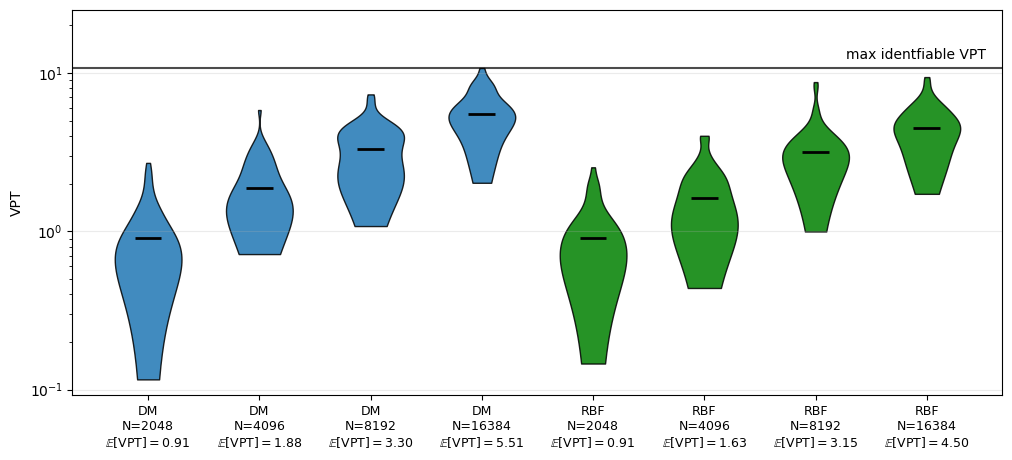

In [3]:
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))

from diffusion_maps import model_dir

import os
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt

filename = lambda mode, map, n : model_dir + f'/ks_chaotic/ks_chaotic_test_result_{mode}_{n}_{map}_vl_4000.pkl'

def load_perf(path):
    if not os.path.exists(path):
        warnings.warn(f"[load_perf] File not found, skipping: {path}")
        return None
    with open(path, "rb") as f:
        perf = pickle.load(f)
    if "vpts_all" not in perf:
        warnings.warn(f"[load_perf] Key 'vpts_all' not found in: {path}. Returning NaN.")
        # Return a 1D array with a single NaN; this will still work with violinplot and nanmean
        return None
    vpts = np.asarray(perf["vpts"], dtype=float)
    vpts_all = np.asarray(perf["vpts_all"], dtype=float)
    vpts_diag = np.diag(vpts_all)
    print(f"mode = {mode}, N = {num_points}| mean vpt = {np.mean(vpts):.3f}, std vpt = {np.std(vpts):.3f}")

    return vpts_diag


def plot_vpt_for_maptype(labels_base, vpt_list, *,
                         digits=2, widths=0.6, color='C0',
                         color_list=None,
                         logy=False, show_means_markers=True):
    
    n = len(labels_base)
    x = np.arange(1, n + 1)

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    vp = ax.violinplot(
        vpt_list,
        positions=x,
        widths=widths,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    if color_list is None:
        color_list = [color] * len(vpt_list)

    for body, c in zip(vp['bodies'], color_list):
        body.set_facecolor(c)
        body.set_edgecolor('black')
        body.set_alpha(0.85)
        body.set_linewidth(1)

    vpt_mean = np.array([np.nanmean(v) for v in vpt_list])
    if show_means_markers:
        for xi, mv in zip(x, vpt_mean):
            ax.hlines(
                mv,
                xi - 0.12,
                xi + 0.12,
                color='black',
                linewidth=2,
                zorder=5,
            )

    if logy:
        ax.set_yscale('log')
    ax.set_ylabel("VPT")

    labels_with_means = []
    for base, mv in zip(labels_base, vpt_mean):
        labels_with_means.append(
            f"{base}\n"
            r"$\mathbb{E}[\mathrm{VPT}]=" + f"{mv:.{digits}f}$"
        )

    ax.set_xticks(x)
    ax.set_xticklabels(labels_with_means, rotation=0, fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)

    yline = 250 * 0.043
    ax.axhline(
        y=yline,
        color="k",
        linewidth=1.5,
        alpha=0.7,
        linestyle="-"
    )
    ax.set_ylim([-1, 25])
    ax.text(
        7.9,
        yline + 1,
        "max identfiable VPT",
        ha="center",
        va="bottom",
        color="k",
    )
    return fig


digits=2
logy=True

mode_lst = ["diffusion", "rbf"]
mode_label = {"diffusion": "DM", "rbf": "RBF"}
mode_to_color = {"diffusion": "C0", "rbf": "g"}

map_type = 'direct'
num_points_lst = [2048, 4096, 8192, 16384]

vpt_lst = []
labels_base = []
color_list = []
for mode in mode_lst:
    for num_points in num_points_lst:
        v = load_perf(filename(mode, map_type, num_points))
        if v is None:
            continue
        vpt_lst.append(v)
        labels_base.append(mode_label[mode] + f'\nN={num_points}')
        color_list.append(mode_to_color[mode])
        


fig = plot_vpt_for_maptype(
    labels_base, vpt_lst,
    digits=digits,
    logy=logy,
    show_means_markers=True,
    color_list=color_list,
)

fig.savefig(f"./pics/ks_chaotic_violin_{map_type}_logy.png",
            dpi=600, bbox_inches="tight", transparent=True)
